# [CDAF] Atividade 5

## Nome e matrícula
Nome: Lucas Affonso Pires
Matrícula: 2023028420

## Referências
- [1] https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
- [2] https://github.com/metrica-sports/sample-data

## Introdução
Nessa atividade vamos abrir, manipular e fazer algumas análises com os dados de tracking

## Carregando os dados

Acesse [2] e baixe os arquivos do repositório em formato ZIP.

Depois extraia os arquivos pra uma pasta local.

Substitua o caminho da pasta com os jogos de amostra no código abaixo.

In [59]:
DATADIR = 'sample-data-master/data'

In [60]:
import os
import pandas as pd
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import matplotlib.pyplot as plt
import numpy as np
import re
from mplsoccer import Pitch

## Parte 1

Escolha um dos jogos disponíveis na pasta. Repare que os dados estão anonimizados, então não é possível saber quem são os times e jogadores envolvidos.

In [61]:
game_id = 2

In [62]:
events = mio.read_event_data(DATADIR, game_id)
events = mio.to_metric_coordinates(events)

Utilizando os códigos disponíveis em [1] e o tutorial "Tutorial1_GettingStarted.py", carregue os dados de evento e os frames de tracking das duas equipes envolvidas no jogo escolhido.

Em seguida, faça um plot de um evento de gol ou finalização, acrescentando a posição dos jogadores sem bola de ambas as equipes.

In [63]:
home_events = events[events['Team'] == 'Home']
goal_events = home_events[(home_events['Type'] == 'SHOT') & (home_events['Subtype'].str.contains('-GOAL'))]

if goal_events.empty:
    raise ValueError("Nenhum evento de gol encontrado para a equipe da casa.")

goal_event = goal_events.iloc[0]

tracking_home = mio.tracking_data(DATADIR, game_id, 'Home')
tracking_away = mio.tracking_data(DATADIR, game_id, 'Away')
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

Reading team: home
Reading team: away


In [64]:
goal_frame = int(goal_event['Start Frame'])

tracking_home_frame = tracking_home.loc[goal_frame]
tracking_away_frame = tracking_away.loc[goal_frame]

home_players_positions = tracking_home_frame.filter(regex='Home_\d+_x')
away_players_positions = tracking_away_frame.filter(regex='Away_\d+_x')

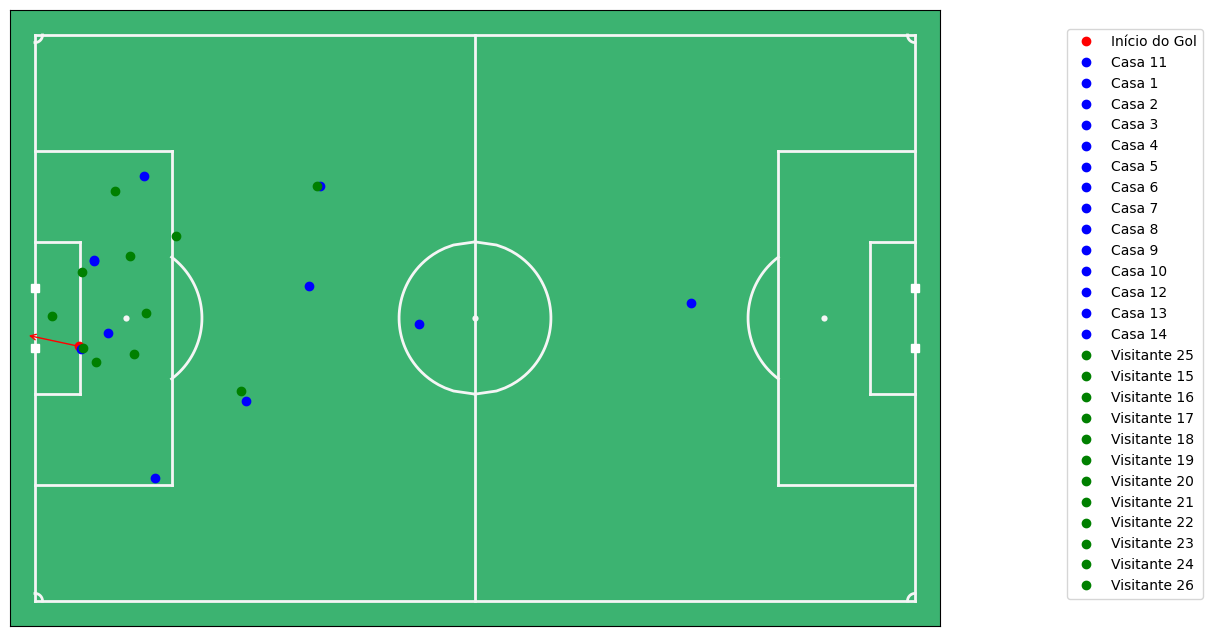

In [65]:
fig, ax = mviz.plot_pitch()
ax.plot(goal_event['Start X'], goal_event['Start Y'], 'ro', label='Início do Gol')
ax.annotate("", xy=(goal_event['End X'], goal_event['End Y']),
            xytext=(goal_event['Start X'], goal_event['Start Y']),
            alpha=0.6, arrowprops=dict(arrowstyle="->", color='r'))

for col in home_players_positions.index:
    player_id = col.split('_')[1]
    x_col = col
    y_col = col.replace('_x', '_y')
    ax.plot(tracking_home_frame[x_col], tracking_home_frame[y_col], 'bo', label=f'Casa {player_id}')

for col in away_players_positions.index:
    player_id = col.split('_')[1]
    x_col = col
    y_col = col.replace('_x', '_y')
    ax.plot(tracking_away_frame[x_col], tracking_away_frame[y_col], 'go', label=f'Visitante {player_id}')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), bbox_transform=fig.transFigure)
plt.show()

Agora faça um plot descrevendo a trajetória do jogador que finalizou considerando os 1500 frames anteriores ao gol/finalização

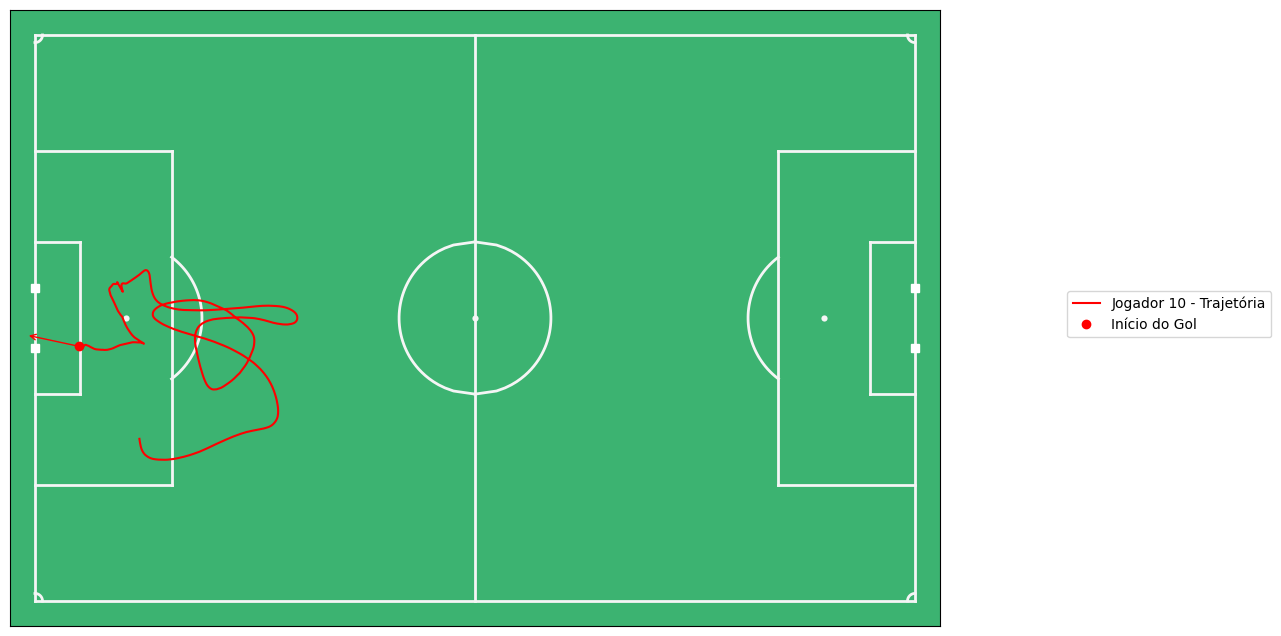

In [66]:
def extract_player_id(player_str):
    match = re.search(r'\d+', player_str)
    return int(match.group()) if match else None

player_id = extract_player_id(goal_event['From'])
if player_id is None:
    raise ValueError(f"Não foi possível extrair o ID do jogador de '{goal_event['From']}'")

goal_frame = int(goal_event['Start Frame'])
start_frame = max(0, goal_frame - 1500)  

fig, ax = mviz.plot_pitch()
ax.plot(tracking_home[f'Home_{player_id}_x'].iloc[start_frame:goal_frame],
        tracking_home[f'Home_{player_id}_y'].iloc[start_frame:goal_frame],
        'r-', label=f'Jogador {player_id} - Trajetória')

ax.plot(goal_event['Start X'], goal_event['Start Y'], 'ro', label='Início do Gol')
ax.annotate("", xy=(goal_event['End X'], goal_event['End Y']),
            xytext=(goal_event['Start X'], goal_event['Start Y']),
            alpha=0.6, arrowprops=dict(arrowstyle="->", color='r'))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), bbox_transform=fig.transFigure)

plt.show()

## Parte 2

Utilize o código de "Tutorial2_DelvingDeeper.py" para calcular as velocidades dos jogadores em cada frame. Em seguida faça o plot de um frame qualquer incluindo vetores de velocidade.

In [67]:
game_id = 1

events = mio.read_event_data(DATADIR, game_id)

tracking_home = mio.tracking_data(DATADIR, game_id, 'Home')
tracking_away = mio.tracking_data(DATADIR, game_id, 'Away')

tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

def to_single_playing_direction(home, away, events):
    '''
    Reverte as coordenadas no segundo tempo para que cada time sempre ataque na mesma direção durante a partida.
    '''
    for team in [home, away, events]:
        second_half_idx = team[team['Period'] == 2].index[0]
        columns = [c for c in team.columns if c[-1].lower() in ['x', 'y']]
        team.loc[second_half_idx:, columns] *= -1
    return home, away, events

tracking_home, tracking_away, events = to_single_playing_direction(tracking_home, tracking_away, events)

def calc_player_velocities(team, team_name, smoothing=True, filter_='moving_average', window=7, polyorder=1, maxspeed=12):
    player_ids = np.unique( [c.split('_')[1] for c in team.columns if c[:4] in ['Home','Away']] )

    dt = team['Time [s]'].diff()

    second_half_idx = team[team['Period'] == 2].index[0]

    for player in player_ids:
        vx = team['{}_{}_x'.format(team_name, player)].diff() / dt
        vy = team['{}_{}_y'.format(team_name, player)].diff() / dt

        if smoothing:
            if filter_ == 'moving_average':
                vx = vx.rolling(window=window, min_periods=1, center=True).mean()
                vy = vy.rolling(window=window, min_periods=1, center=True).mean()
            elif filter_ == 'savitzky_golay':
                from scipy.signal import savgol_filter
                vx = savgol_filter(vx, window_length=window, polyorder=polyorder)
                vy = savgol_filter(vy, window_length=window, polyorder=polyorder)

        team['{}_{}_vx'.format(team_name, player)] = vx
        team['{}_{}_vy'.format(team_name, player)] = vy

        team['{}_{}_speed'.format(team_name, player)] = np.sqrt(vx**2 + vy**2)

    return team

Reading team: home
Reading team: away


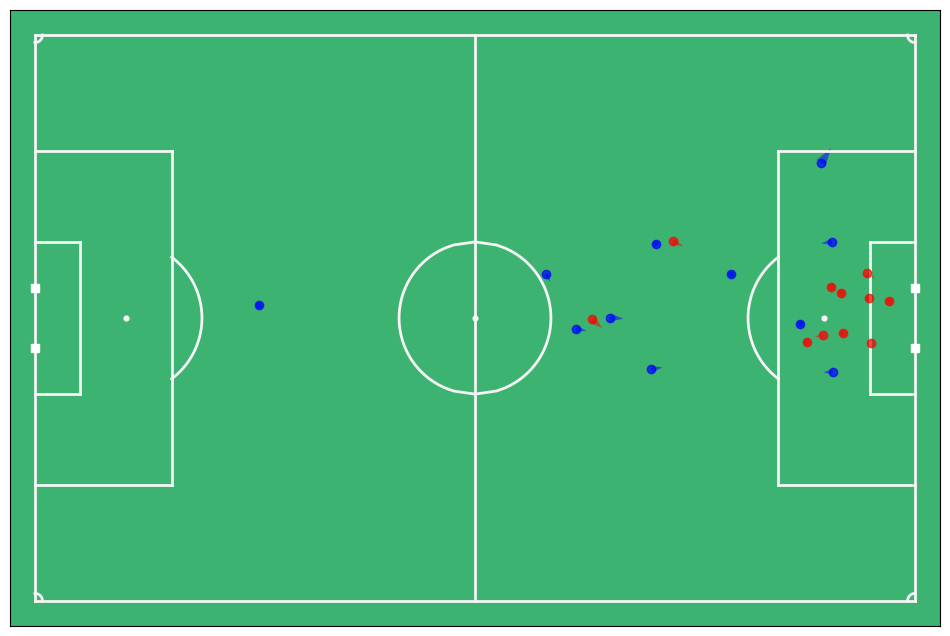

In [68]:
tracking_home = calc_player_velocities(tracking_home, 'Home', smoothing=True)
tracking_away = calc_player_velocities(tracking_away, 'Away', smoothing=True)

frame_id = 10000
fig, ax = mviz.plot_pitch()
home_frame = tracking_home.loc[frame_id]
away_frame = tracking_away.loc[frame_id]

ax.plot(home_frame.filter(regex='_x').values, home_frame.filter(regex='_y').values, 'bo', alpha=0.7)

ax.plot(away_frame.filter(regex='_x').values, away_frame.filter(regex='_y').values, 'ro', alpha=0.7)

for player in [col.split('_')[1] for col in tracking_home.columns if 'Home' in col and '_x' in col]:
    x = home_frame[f'Home_{player}_x']
    y = home_frame[f'Home_{player}_y']
    vx = home_frame[f'Home_{player}_vx']
    vy = home_frame[f'Home_{player}_vy']
    ax.quiver(x, y, vx, vy, color='b', scale_units='xy', scale=1, alpha=0.5)

for player in [col.split('_')[1] for col in tracking_away.columns if 'Away' in col and '_x' in col]:
    x = away_frame[f'Away_{player}_x']
    y = away_frame[f'Away_{player}_y']
    vx = away_frame[f'Away_{player}_vx']
    vy = away_frame[f'Away_{player}_vy']
    ax.quiver(x, y, vx, vy, color='r', scale_units='xy', scale=1, alpha=0.5)

plt.show()

Crie um resumo físico para os jogadores envolvidos na partida. Plote as distâncias percorridas por cada jogador em cada ritmo (walking, jogging, running, sprinting)

Você consegue dizer a partir desse resumo quais jogadores são os goleiros?

In [69]:
def calc_distance_by_speed_category(tracking, team_name):
    speed_categories = {
        'walking': (0, 2),
        'jogging': (2, 4),
        'running': (4, 6),
        'sprinting': (6, np.inf)
    }

    player_ids = np.unique([col.split('_')[1] for col in tracking.columns if col.startswith(team_name)])

    distances = {player: {category: 0 for category in speed_categories.keys()} for player in player_ids}

    for player in player_ids:
        speed = tracking[f'{team_name}_{player}_speed']
        dt = tracking['Time [s]'].diff()
        for category, (min_speed, max_speed) in speed_categories.items():
            mask = (speed >= min_speed) & (speed < max_speed)
            distances[player][category] = (speed[mask] * dt[mask]).sum()

    return distances

In [70]:
distances_home = calc_distance_by_speed_category(tracking_home, 'Home')
distances_away = calc_distance_by_speed_category(tracking_away, 'Away')

def plot_distances(distances, team_name):
    categories = list(next(iter(distances.values())).keys())
    players = list(distances.keys())
    num_players = len(players)
    bar_width = 0.2  
    index = np.arange(num_players)  

    fig, ax = plt.subplots(figsize=(14, 7))

    for i, category in enumerate(categories):
        category_distances = [distances[player][category] for player in players]
        ax.bar(index + i * bar_width, category_distances, bar_width, label=category)

    ax.set_xlabel('Players')
    ax.set_ylabel('Distance (m)')
    ax.set_title(f'Distances Covered by {team_name} Players in Different Speed Categories')
    ax.set_xticks(index + bar_width * (len(categories) - 1) / 2)
    ax.set_xticklabels(players)
    ax.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

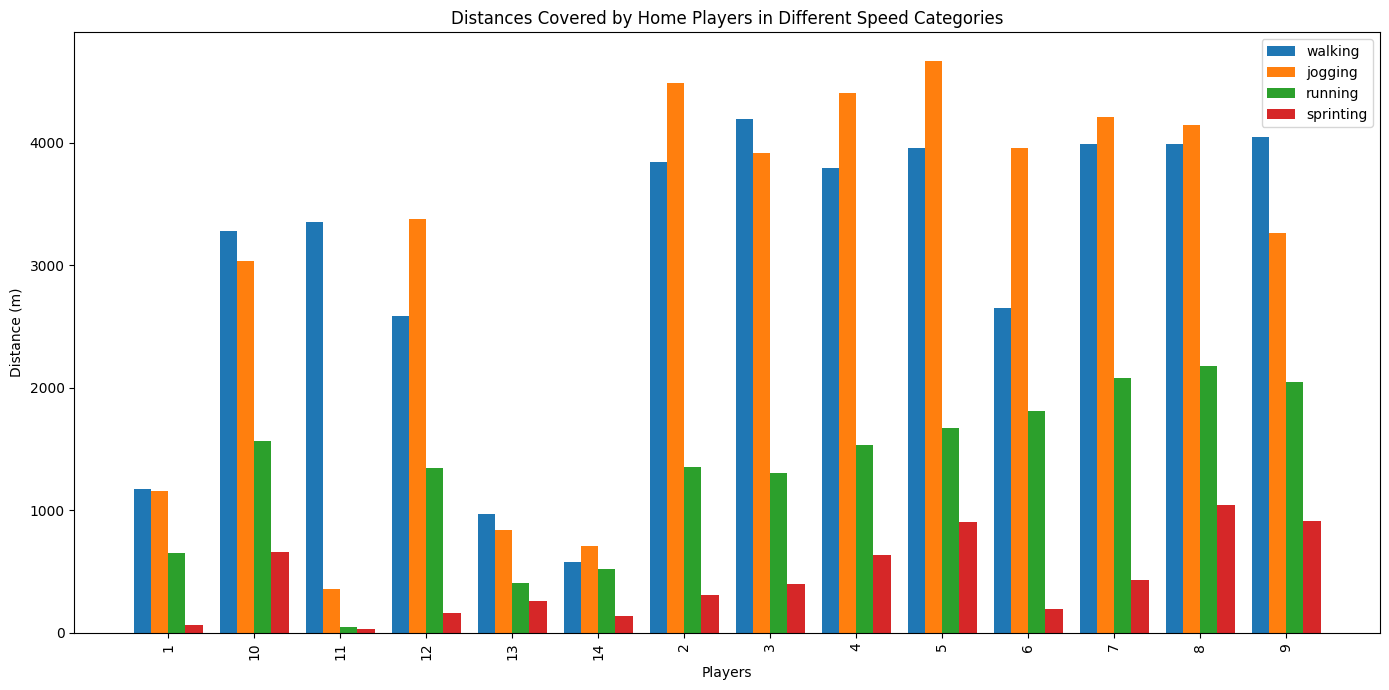

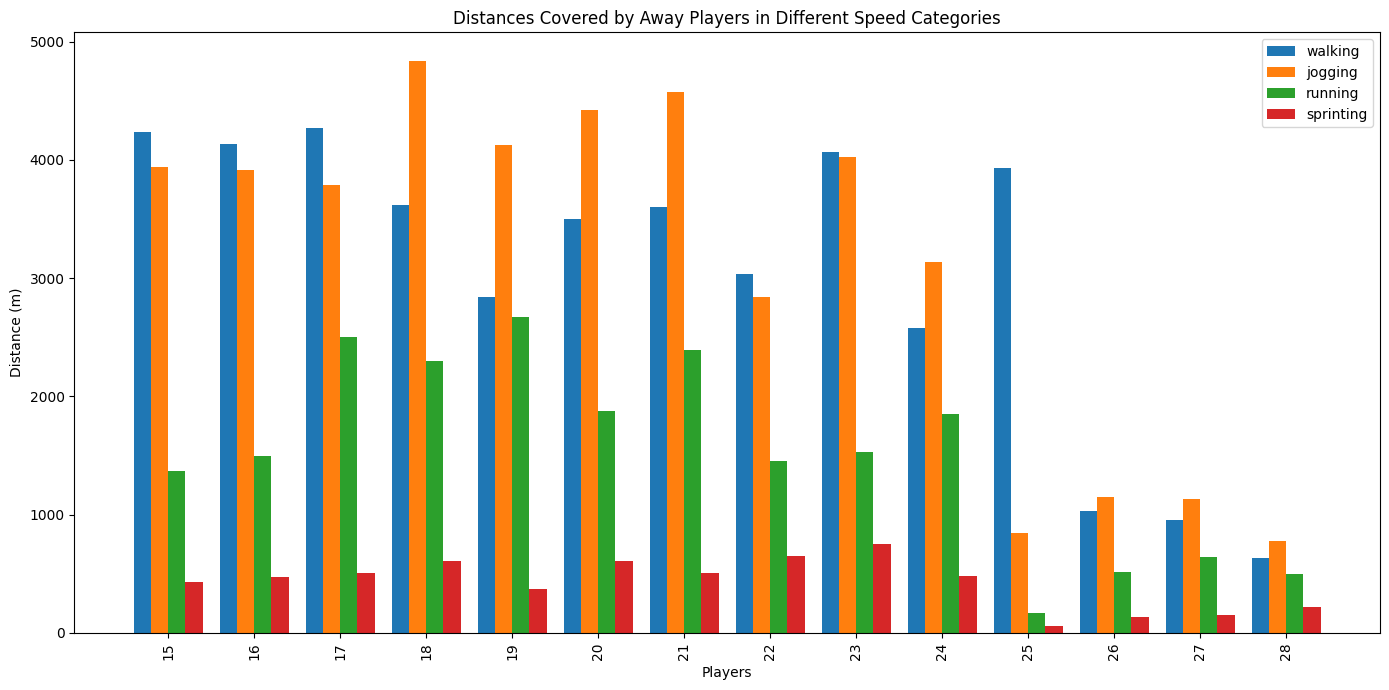

In [71]:
plot_distances(distances_home, 'Home')

plot_distances(distances_away, 'Away')

Por fim, escolha um jogador e faça um plot com seus sprints no campo

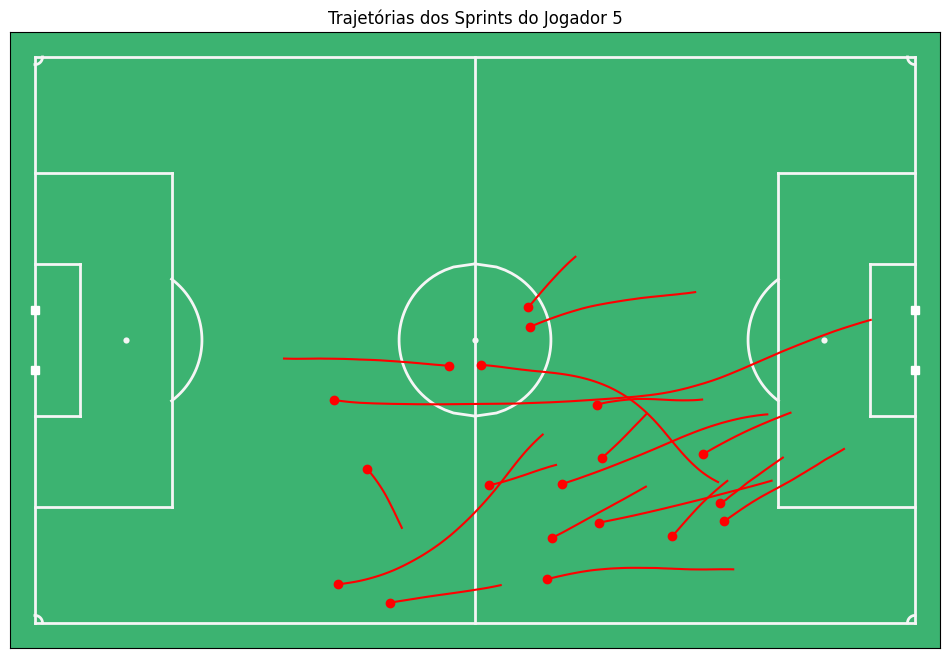

In [72]:
player = '5'
sprint_threshold = 7  
sprint_window = 1 * 25  

column_speed = f'Home_{player}_speed'
player_sprints = np.diff(1 * (np.convolve(1 * (tracking_home[column_speed] >= sprint_threshold), np.ones(sprint_window), mode='same') >= sprint_window))
sprints_start = np.where(player_sprints == 1)[0] - int(sprint_window / 2) + 1
sprints_end = np.where(player_sprints == -1)[0] + int(sprint_window / 2) + 1

fig, ax = mviz.plot_pitch()

for start, end in zip(sprints_start, sprints_end):
    ax.plot(tracking_home[f'Home_{player}_x'].iloc[start], tracking_home[f'Home_{player}_y'].iloc[start], 'ro')  # ponto inicial
    ax.plot(tracking_home[f'Home_{player}_x'].iloc[start:end+1], tracking_home[f'Home_{player}_y'].iloc[start:end+1], 'r')  # trajetória do sprint

plt.title(f'Trajetórias dos Sprints do Jogador {player}')
plt.show()